In [1]:
import pandas as pd
ratings=pd.read_csv(r"C:\Users\Tejsv Gupta\Documents\3RD YEAR\ml\lab\ratings.csv")
movies=pd.read_csv(r"C:\Users\Tejsv Gupta\Documents\3RD YEAR\ml\lab\movies.csv")
ratings.head()

MemoryError: 

In [ ]:
movies.head()

In [22]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [28]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
    
genre_ratings = get_genre_ratings(ratings, movies, ['Comedy', 'Drama'], ['avg_comedy_rating', 'avg_drama_rating'])
genre_ratings.head()

,avg_comedy_rating,avg_drama_rating
1,4.28,4.53
2,4.00,3.88
3,1.00,0.75
4,3.51,3.48
5,3.47,3.80


In [35]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_comedy_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_drama_rating'] > score_limit_2)) | ((genre_ratings['avg_drama_rating'] < score_limit_1) & (genre_ratings['avg_comedy_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
    
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  106


,index,avg_comedy_rating,avg_drama_rating
0,7,3.16,3.13
1,10,3.27,3.15
2,14,2.71,3.71
3,19,2.64,2.61
4,21,3.20,2.95


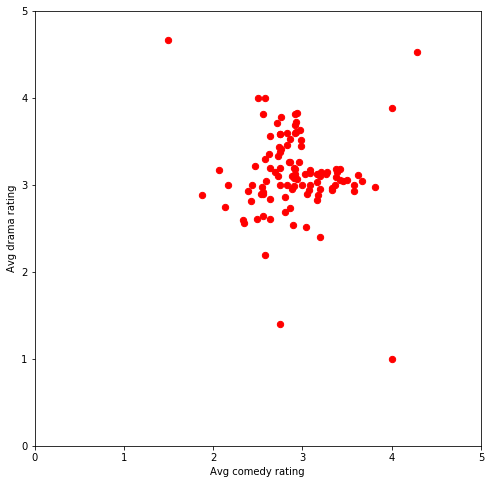

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, c='red', marker='o', s=40)


draw_scatterplot(biased_dataset['avg_comedy_rating'],'Avg comedy rating', biased_dataset['avg_drama_rating'], 'Avg drama rating')

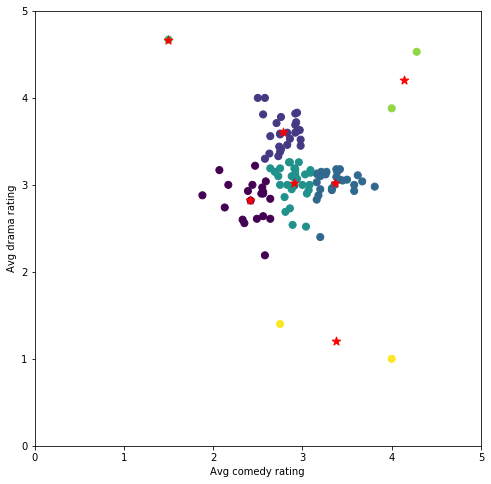

In [64]:
# Taking k=7 in  means clustering

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0)
X = biased_dataset[['avg_comedy_rating','avg_drama_rating']].values

def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg comedy rating')
    ax.set_ylabel('Avg drama rating')
    

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_comedy_rating'], clustered['avg_drama_rating'], c=clustered['group'], s=50, cmap=cmap)

# Plot
predictions = kmeans.fit_predict(X)
draw_clusters(biased_dataset, predictions)

plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            s=80,
            marker='*',
            c='red',
            label='centroids')

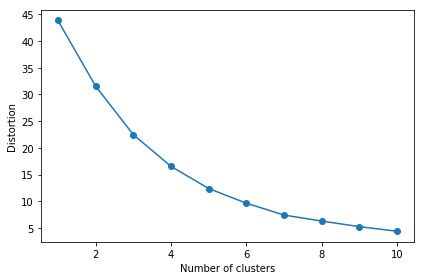

In [59]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()

plt.show()

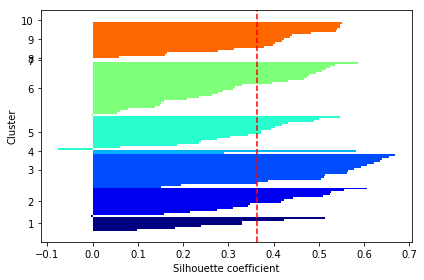

In [60]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
km = KMeans(n_clusters=10, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()

plt.show()

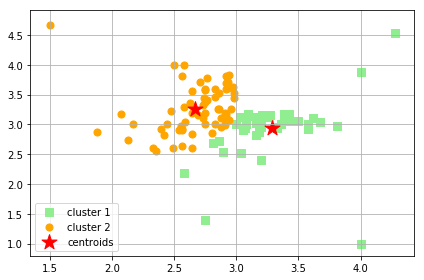

In [61]:

km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()



#SOFT CLUSTERING - FUZZY C MEANS

km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids_bad.png', dpi=300)
plt.show()



cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()


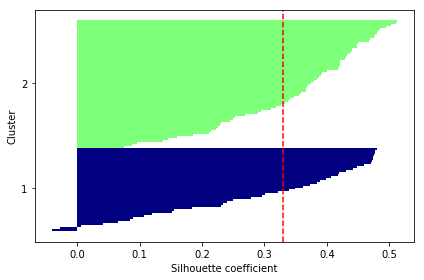

In [62]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()

plt.show()